In [2]:
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/wheat_t2_dnn_kcv_testdata_segregated.h5'

In [3]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold

print(tf.__version__)

2023-07-25 14:03:29.487733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [4]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-25 14:03:33.101324: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-25 14:03:33.101825: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-25 14:03:33.121311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 14:03:33.121407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2023-07-25 14:03:33.121428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-25 14:03:33.546208: I tensorflow/stream_executor/platform/d

In [5]:
def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(trueValues, predictions)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label='Ideal fit')
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Real", fontsize = 14)
  plt.ylabel("Predictions", fontsize = 14)
  plt.grid()

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [6]:
#url dataset
URL = "../Datasets/processed/Wheat.csv"

#read in excel format
df = pd.read_csv(URL)

print("From USDA: ", URL)

df.head()

From USDA:  ../Datasets/processed/Wheat.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238


# 2. Overview of data


In [7]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,402.500000,10.811414,7.088834,16.189541,0.796298,18.410033,-4.604663,-633.488065,2.912112,0.499187
std,232.816451,3.530055,1.554604,3.794772,0.067384,5.946835,101.951444,219.510760,0.305758,0.186739
min,0.000000,5.000000,4.400000,10.260000,0.625400,8.002300,-179.335000,-1274.435000,2.340000,0.220000
25%,201.250000,8.000000,6.500000,13.680000,0.745400,13.524700,-88.842000,-793.405750,2.688500,0.337000
50%,402.500000,11.000000,7.700000,16.225000,0.801300,18.131600,-9.838500,-602.380500,2.861500,0.470500
75%,603.750000,13.000000,7.700000,18.810000,0.842000,23.098000,80.957250,-456.055750,3.109750,0.639000
max,805.000000,18.000000,8.900000,24.410000,0.927800,29.897000,179.048000,-235.044000,4.038000,0.987000


In [8]:
# Dimension of the dataset
df.shape

(806, 11)

In [9]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [10]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary']]

df_targets = df[['M%', 'Density']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [11]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.2
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalizing (train+val) data

In [12]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining model

2023-07-25 14:03:35.832483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 14:03:35.833436: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-25 14:03:35.833636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 14:03:35.833712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth

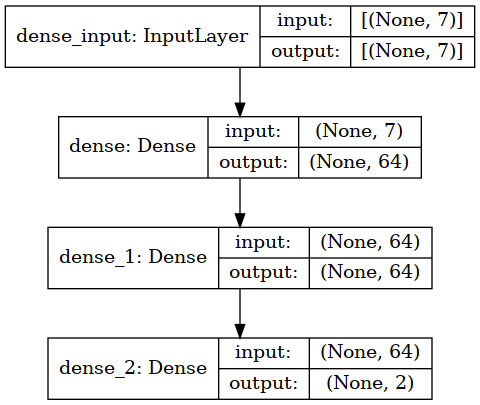

In [13]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  my_model = Sequential([
    
    layers.Dense(64, input_shape=(7,), activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='linear')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)

## Running model with KCV

In [28]:
from sklearn.model_selection import KFold
import numpy as np

K_FOLD_SPLITS = 10
NUM_EPOCHS = 50
BATCH_SIZE = 5

# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y1 = y_train_norm[:,0]
Y2 = y_train_norm[:,1]
targets = (Y1, Y2)

X = X_train_norm

i = 0
arr_loss = list()
arr_rmse = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, valX = np.array(X[train_indices]), np.array(X[test_indices])
  trainY = np.vstack((Y1[train_indices], Y2[train_indices])).T
  valY = np.vstack((Y1[test_indices], Y2[test_indices])).T

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (valX, valY)
  )


  #testing on validation set process
  loss, rmse = model.evaluate(x = valX, y = valY, verbose=1)
  print(f"Loss = {loss}, rmse = {rmse}" )

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  arr_rmse.append(rmse)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

####################### Iteration   0  #######################
Epoch 1/50
99/99 [==============================] - 0s 1ms/step - loss: 0.3455 - accuracy: 0.5432 - val_loss: 0.1073 - val_accuracy: 0.8182
Epoch 2/50
99/99 [==============================] - 0s 746us/step - loss: 0.1064 - accuracy: 0.6952 - val_loss: 0.0424 - val_accuracy: 0.9091
Epoch 3/50
99/99 [==============================] - 0s 737us/step - loss: 0.0508 - accuracy: 0.7834 - val_loss: 0.0294 - val_accuracy: 0.9273
Epoch 4/50
99/99 [==============================] - 0s 884us/step - loss: 0.0367 - accuracy: 0.8186 - val_loss: 0.0220 - val_accuracy: 0.9455
Epoch 5/50
99/99 [==============================] - 0s 873us/step - loss: 0.0260 - accuracy: 0.8185 - val_loss: 0.0175 - val_accuracy: 0.8364
Epoch 6/50
99/99 [==============================] - 0s 929us/step - loss: 0.0223 - accuracy: 0.8132 - val_loss: 0.0146 - val_accuracy: 0.8000
Epoch 7/50
99/99 [==============================] - 0s 934us/step - loss: 0.0187 - accu

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No handles with labels found to put in legend.


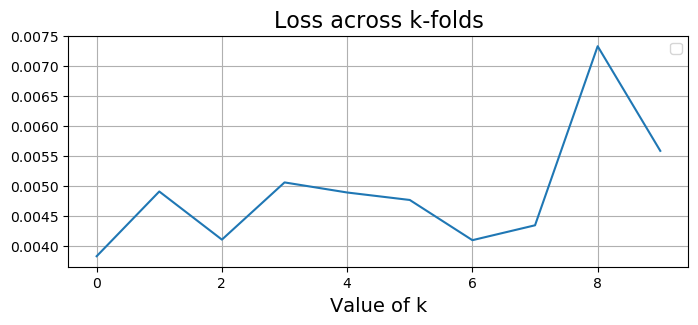

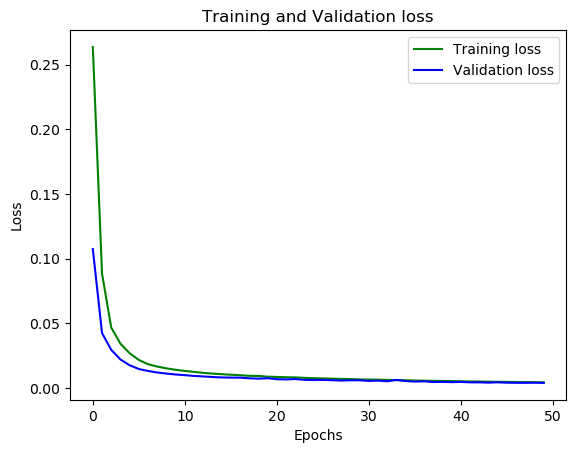

In [29]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

### PREDICTION on Test Dataset

In [30]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

Maxval here is:  24.41
Maxval here is:  0.9278


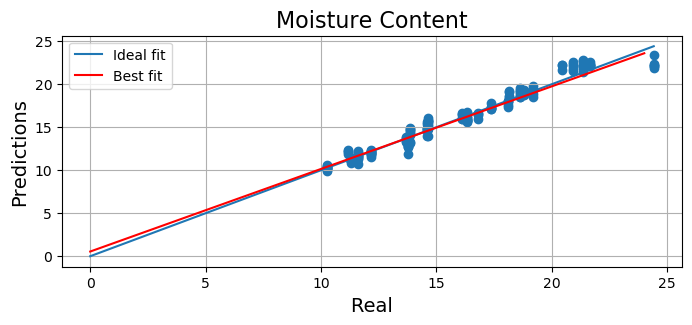

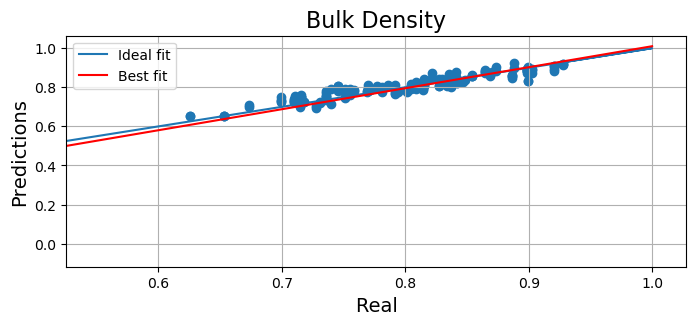

In [31]:
Y_pred_normalized = best_model.predict(X_test_norm)
Y_pred = scaler_output.inverse_transform(Y_pred_normalized)

Y_actual = np.array(y_test)

# Moisture Content

scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")

a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()

# Bulk Density

scatter_plot(predictions=Y_pred[:,1], trueValues=Y_actual[:,1], title="Bulk Density")
plt.xlim([min(min(Y_pred[:,1]), min(Y_actual[:,1]))-0.1, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1])
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [32]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#    - find line of best fit
a, b = np.polyfit(Y_actual[:, 0], Y_pred[:, 0], 1) # y = ax + b

#   - R-squared
mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print(mc_r2_score)

# BULK DENSITY
#    - find line of best fit
a, b = np.polyfit(Y_actual[:, 1], Y_pred[:, 1], 1) # y = ax + b

#   - R-squared
bd_r2_score = r2_score(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print(bd_r2_score)

0.9591403502230119
0.8761559249213391
